<a href="https://colab.research.google.com/github/kishan20-00/Flowers_Detection_with_Transfer_Learning/blob/main/Flowers_Detection_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers


In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Download the dataset using TensorFlow

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# Print Information about the Flowers Dataset

In [4]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat images and Create Batches

In [6]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# Simple Transfer Learning withTensorFlow Hub

In [7]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

Freeze the pretrained model

In [8]:
feature_extractor.trainable = False

# Attaching a classification head

In [9]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Train the model

In [10]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 21s 124ms/step - loss: 0.7837 - accuracy: 0.7042 - val_loss: 0.4610 - val_accuracy: 0.8420
Epoch 2/6
81/81 [==============================] - 6s 74ms/step - loss: 0.3847 - accuracy: 0.8712 - val_loss: 0.3614 - val_accuracy: 0.8819
Epoch 3/6
81/81 [==============================] - 5s 59ms/step - loss: 0.3000 - accuracy: 0.8961 - val_loss: 0.3236 - val_accuracy: 0.8955
Epoch 4/6
81/81 [==============================] - 6s 78ms/step - loss: 0.2512 - accuracy: 0.9179 - val_loss: 0.3141 - val_accuracy: 0.9037
Epoch 5/6
81/81 [==============================] - 4s 48ms/step - loss: 0.2158 - accuracy: 0.9362 - val_loss: 0.2890 - val_accuracy: 0.9055
Epoch 6/6
81/81 [==============================] - 5s 67ms/step - loss: 0.1885 - accuracy: 0.9478 - val_loss: 0.2773 - val_accuracy: 0.9119


Plot training and validation graphs

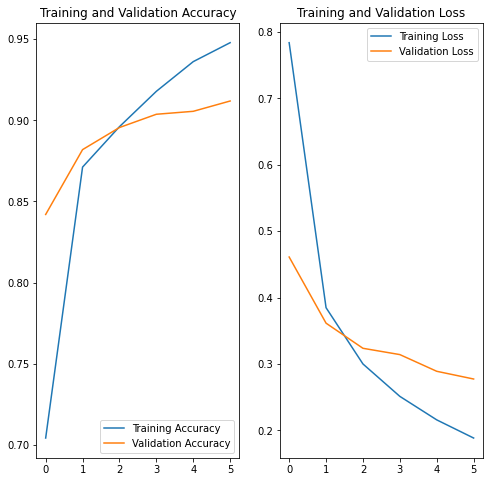

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Check Predictions

In [12]:
class_names = np.array(dataset_info.features['label'].names)

print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


Create an Image Batch and make predictions

In [13]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

1/1 [==============================] - 0s 486ms/step
['tulips' 'roses' 'daisy' 'roses' 'dandelion' 'roses' 'sunflowers'
 'dandelion' 'tulips' 'sunflowers' 'sunflowers' 'roses' 'dandelion'
 'sunflowers' 'dandelion' 'daisy' 'tulips' 'dandelion' 'daisy' 'dandelion'
 'tulips' 'dandelion' 'roses' 'dandelion' 'dandelion' 'sunflowers' 'roses'
 'dandelion' 'dandelion' 'roses' 'tulips' 'daisy']


Print True labels and Predicted Indices

In [14]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [2 4 1 4 0 4 3 0 2 3 3 4 0 3 0 1 2 0 1 0 2 0 4 0 0 3 4 0 0 4 2 1]
Predicted labels:  [2 4 1 4 0 4 3 0 2 3 3 4 0 3 0 1 2 0 1 0 2 0 4 0 0 3 4 0 0 4 2 1]


Plot Model Predictions

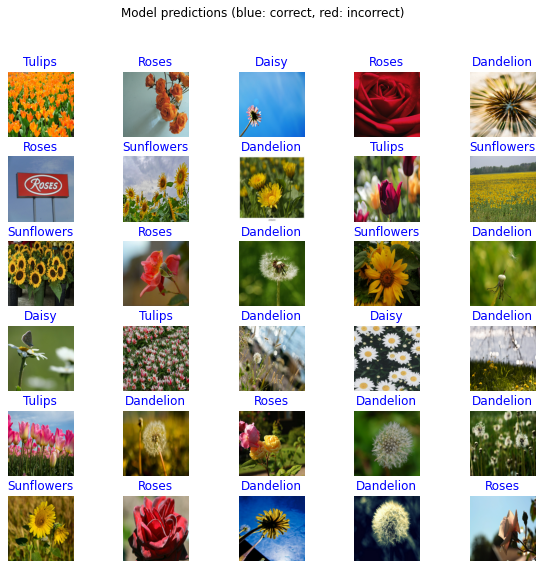

In [15]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

Perform Transfer Learning with Inception model

In [16]:
IMAGE_RES = 299

(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:70%]', 'train[70%:]'],
)
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
  input_shape=(IMAGE_RES, IMAGE_RES, 3),
  trainable=False)

model_inception = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])

model_inception.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2048)              21802784  
                                                                 
 dense_1 (Dense)             (None, 5)                 10245     
                                                                 
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
model_inception.compile(
  optimizer='adam', 
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6

history = model_inception.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 26s 212ms/step - loss: 0.7458 - accuracy: 0.7431 - val_loss: 0.5146 - val_accuracy: 0.8211
Epoch 2/6
81/81 [==============================] - 14s 173ms/step - loss: 0.3925 - accuracy: 0.8747 - val_loss: 0.3610 - val_accuracy: 0.8847
Epoch 3/6
81/81 [==============================] - 15s 186ms/step - loss: 0.3093 - accuracy: 0.9035 - val_loss: 0.3243 - val_accuracy: 0.8837
Epoch 4/6
81/81 [==============================] - 14s 175ms/step - loss: 0.2638 - accuracy: 0.9194 - val_loss: 0.2927 - val_accuracy: 0.8992
Epoch 5/6
81/81 [==============================] - 14s 172ms/step - loss: 0.2268 - accuracy: 0.9315 - val_loss: 0.2900 - val_accuracy: 0.9010
Epoch 6/6
81/81 [==============================] - 14s 173ms/step - loss: 0.2047 - accuracy: 0.9408 - val_loss: 0.2879 - val_accuracy: 0.8955
